In [123]:
%pip install tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline
device = torch.device("cpu")
# this ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
True
True


In [124]:
words = open('names.txt').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [125]:
len(words)

32033

In [126]:
chars = sorted(list(set(''.join(words))))
stoi = {c: i+1 for i, c in enumerate(chars)}
stoi['.']=0
itos = {i: c for c, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [127]:
# build the dataset
block_size = 3 # context length: 3 characters to predict the next one


def build_dataset(words):
    X, Y = [], []
    for w in words:

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, X.dtype, Y.shape, Y.dtype)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.int64 torch.Size([182625]) torch.int64
torch.Size([22655, 3]) torch.int64 torch.Size([22655]) torch.int64
torch.Size([22866, 3]) torch.int64 torch.Size([22866]) torch.int64


In [128]:
# Now make it clean:
n_chars = len(chars)+1
embedding_dimensions = 10
n_hidden = 400
n_inputs = block_size * embedding_dimensions
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((n_chars, embedding_dimensions), generator=g)
W1 = torch.randn((n_inputs, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, n_chars), generator=g)
b2 = torch.randn(n_chars, generator=g)
parameters = [C, W1, b1, W2, b2]


for p in parameters:
    p.requires_grad = True

sum(p.numel() for p in parameters)

23497

In [129]:
lri = []
lossi = []
stepi = []

In [154]:
batch_size =32
for i in tqdm(range(100000)):
    # mini-batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))

    # forward pass
    emb = C[Xtr[ix]] # 32, 3, 2
    h = torch.tanh(emb.view(-1, n_inputs) @ W1 + b1) # 32, 100
    logits = h @ W2 + b2 # 32, 27
    #counts = logits.exp()
    #prob = counts / counts.sum(1, keepdim=True)
    #loss = -prob[torch.arange(32), Y].log().mean()
    # equivalent to
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.005 # determined by experiment lrs[i]
    for p in parameters:
        p.data -= lr * p.grad

    #lri.append(lr)
    lossi.append(loss.log10().item())
    stepi.append(i)
    

print(loss.item())


100%|██████████| 100000/100000 [00:25<00:00, 3947.33it/s]

2.2620551586151123


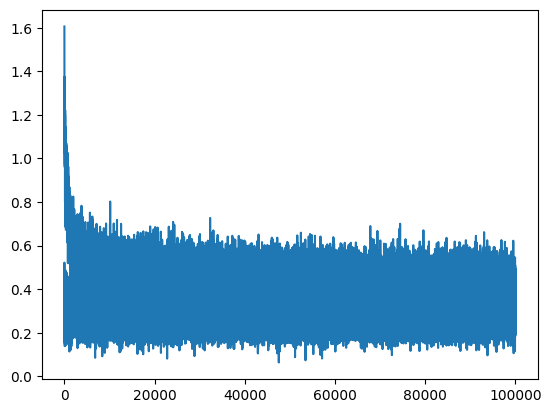

In [155]:
plt.plot(stepi, lossi)

In [156]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, n_inputs) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0711, grad_fn=<NllLossBackward0>)

In [158]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, n_inputs) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1559, grad_fn=<NllLossBackward0>)

In [163]:
emb = C[Xte]
h = torch.tanh(emb.view(-1, n_inputs) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1629, grad_fn=<NllLossBackward0>)

In [162]:
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[ix] for ix in out))

cerberleelynn.
rochuzah.
melliston.
anjamayk.
katar.
samiyah.
javarii.
tai.
molie.
cavo.
keyteda.
kaley.
maside.
eniaviyah.
fobry.
huniven.
tahlas.
kash.
del.
wil.
